In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.stats import qmc

In [2]:
var_percentile = 0.05
np.random.seed(10)
stock_curr_val = 1e6 * np.ones(4)
fixed_rate = 4.2 / 100
one_bee_pee = 0.01 / 100
swap_notional = 100_000_000

## Data Prep ##

In [3]:
sofr_raw = pd.read_excel("hist_data.xlsm", sheet_name="SofrCurve")
aapl_raw = pd.read_excel("hist_data.xlsm", sheet_name="AAPL").set_index("Date")
msft_raw = pd.read_excel("hist_data.xlsm", sheet_name="MSFT").set_index("Date")
f_raw = pd.read_excel("hist_data.xlsm", sheet_name="F").set_index("Date")
bac_raw = pd.read_excel("hist_data.xlsm", sheet_name="BAC").set_index("Date")

In [4]:
# clean up sofr raw
sofr_raw = sofr_raw
sofr_raw.index = sofr_raw["Tenor"]
annualized_time = sofr_raw["T"]
sofr_raw.drop(columns=["T"], inplace=True)
sofr_raw.drop(columns=["Tenor"], inplace=True)
# sofr_raw.columns.name = "Date"

In [5]:
sofr_raw.head()

,2022-10-31,2022-11-01,2022-11-02,2022-11-03,2022-11-04,2022-11-07,2022-11-08,2022-11-09,2022-11-10,2022-11-14,...,2023-10-17,2023-10-18,2023-10-19,2023-10-20,2023-10-23,2023-10-24,2023-10-25,2023-10-26,2023-10-27,2023-10-30
Tenor,,,,,,,,,,,,,,,,,,,,,
1D,0.039191,0.039604,0.039948,0.040389,0.045965,0.040224,0.040339,0.040373,0.052075,0.040975,...,0.052964,0.053038,0.053050,0.053072,0.053090,0.053105,0.052981,0.053047,0.052989,0.052967
1M,0.038721,0.039023,0.039286,0.039585,0.042343,0.039258,0.039211,0.039193,0.043694,0.039174,...,0.053114,0.053102,0.053086,0.053046,0.053077,0.053084,0.053057,0.053089,0.053040,0.053053
2M,0.038670,0.038886,0.039100,0.039350,0.038795,0.039460,0.039420,0.039483,0.038786,0.039732,...,0.053374,0.053284,0.053226,0.053128,0.053191,0.053202,0.053259,0.053218,0.053185,0.053265
3M,0.040536,0.040725,0.040852,0.041154,0.040611,0.041424,0.041406,0.041445,0.040867,0.041627,...,0.053666,0.053561,0.053454,0.053323,0.053404,0.053424,0.053490,0.053414,0.053368,0.053476
6M,0.044577,0.044849,0.044884,0.045281,0.045212,0.045455,0.045334,0.045299,0.044951,0.044918,...,0.054078,0.053989,0.053758,0.053546,0.053638,0.053690,0.053749,0.053567,0.053486,0.053612


In [6]:
# current sofr swap rates
curr_sofr_rate = sofr_raw[sofr_raw.columns[-1]]

In [7]:
aapl_raw.rename(columns={"Adj Close": "adj_close_aapl"}, inplace=True)
msft_raw.rename(columns={"Adj Close": "adj_close_msft"}, inplace=True)
f_raw.rename(columns={"Adj Close": "adj_close_f"}, inplace=True)
bac_raw.rename(columns={"Adj Close": "adj_close_bac"}, inplace=True)

In [8]:
aapl_raw.head()

,adj_close_aapl
Date,
2022-10-31,152.041122
2022-11-01,149.373917
2022-11-02,143.801514
2022-11-03,137.703613
2022-11-04,137.435455


In [9]:
aapl_diff = aapl_raw.pct_change()
msft_diff = msft_raw.pct_change()
f_diff = f_raw.pct_change()
bac_diff = bac_raw.pct_change()

In [10]:
# current stock prices
curr_stock_price = np.array(
    [aapl_raw.iloc[-1], msft_raw.iloc[-1], f_raw.iloc[-1], bac_raw.iloc[-1]]
)
curr_stock_price

array([[169.849197],
       [336.62677 ],
       [  9.62    ],
       [ 25.486582]])

In [11]:
stock_port_n = stock_curr_val / curr_stock_price.flatten()
stock_port_n = stock_port_n.reshape(-1, 1)
stock_port_n.shape

(4, 1)

In [12]:
# combine df?
stock_return = pd.concat([aapl_diff, msft_diff, f_diff, bac_diff], axis=1)
stock_return.dropna(inplace=True)
stock_return

,adj_close_aapl,adj_close_msft,adj_close_f,adj_close_bac
Date,,,,
2022-11-01,-0.017543,-0.017059,0.002244,0.004439
2022-11-02,-0.037305,-0.035368,-0.025373,-0.003039
2022-11-03,-0.042405,-0.026579,0.015314,-0.005542
2022-11-04,-0.001947,0.033326,0.018854,0.025077
2022-11-07,0.003902,0.029270,0.014064,0.005980
...,...,...,...,...
2023-10-24,0.002543,0.003674,-0.007840,-0.003911
2023-10-25,-0.013492,0.030678,0.013169,0.003141
2023-10-26,-0.024606,-0.037514,-0.016464,0.022309


## Moddeling the Joint Distribution of the Daily Risk Factor Changes ##
* For each risk factor, specify how you want to model their changes. As I suggested, one
way is to model the absolute daily changes in the zero rate risk factors and model the
daily relative returns of the stock prices.
* Once the above is specified, follow the approach of each VaR model (parametric/Monte
Carlo/historical) to model the joint distribution of the daily risk factor changes.

For each risk factor, you would need to use the 1-year historical data provided to compute their
daily changes over the 1-year historical period. Using the historical daily changes of the risk
factors, one can then determine the joint distribution of 1-day risk factor changes under each of
the 3 VaR models

* Parametric VaR. The 1-day risk factor changes are assumed to be multivariate-normally
distributed. One can simply estimate the means and covariance matrix of the multivariate
normal distribution using the sample means and convariance matrix calculated from the
historical daily changes.
* Monte Carlo VaR. The 1-day risk factor changes are also assumed to be
multivariate-normally distributed. Hence, one simply follow the same appproach as the
parametric VaR to estimate the means and covariance matrix of the multivariate normal
distribution.
* Historical VaR. The joint distribution of the 1-day risk factor changes is simply given by
the empirical distribution of the 1-year historical sample of daily risk factor changes.
Dr. Tony Wong 4 / 21


## Stock VaR - Parametric ##

This is kinda following the lecture notes. Use the percentage diff

In [13]:
# params
stock_return_mean = stock_return.mean()
stock_return_cov = stock_return.cov()

Prof Tony made a typo in the lecture notes, recall from QF6000 asset pricing
* portfolio mean return = w`R
* portfolio variance = w`Vw

Where w = weights of the portfolio, V is return covariance matrix, R is the return matrix

In [14]:
# my instinct was to use np.dot, but this is easier to read & understand
stock_port_mean = np.matmul(stock_curr_val, stock_return_mean)
stock_port_var = np.matmul(np.matmul(stock_curr_val, stock_return_cov), stock_curr_val)

In [15]:
z_value = norm.ppf(var_percentile)

Z-value formula adapted to our convention for VaR calculation is
$$z = \frac{J-\mu}{\sigma}$$
VaR is deined as
$$ VaR_{\alpha,h} = |J|$$
$$ P(L \leq J) = \alpha $$
The project wants one-tail 95% confidence, so that means $$\alpha = 0.05$$
That means
$$J = |\mu + \sigma \cdot z_{\alpha=0.05}|

In [16]:
var_stock = abs(stock_port_mean + z_value * np.sqrt(stock_port_var))
var_stock

87730.49630401182

## Swap VaR - Parametric ##


Begin with calculating the PV01, we will find the price of the option at T = 0

In [17]:
start_df = pd.concat([annualized_time, sofr_raw[sofr_raw.columns[-1]]], axis=1)
start_df["disc_factor"] = np.exp(-start_df["T"] * start_df[start_df.columns[1]])

In [18]:
pv_fix = (
    start_df.loc["1Y", "disc_factor"]
    + start_df.loc["2Y", "disc_factor"]
    + start_df.loc["3Y", "disc_factor"]
    + start_df.loc["4Y", "disc_factor"]
    + start_df.loc["5Y", "disc_factor"]
    + start_df.loc["6Y", "disc_factor"]
    + start_df.loc["7Y", "disc_factor"]
    + start_df.loc["8Y", "disc_factor"]
    + start_df.loc["9Y", "disc_factor"]
    + start_df.loc["10Y", "disc_factor"]
) * fixed_rate
pv_float = 1 - start_df.loc["10Y", "disc_factor"]
pv_total = pv_float - pv_fix

we tickle each of the zero rates by 1bp

In [19]:
start_df_tickled = start_df.iloc[6:16,].copy()

In [20]:
start_df_tickled.drop(columns=["disc_factor"], inplace=True)
tickled_pv = []

In [21]:
# this is highly inneficient but it works so stop complaining
for tenor in start_df_tickled.index:
    # add one bee pee
    start_df_tickled.loc[tenor, start_df_tickled.columns[1]] = (
        start_df_tickled.loc[tenor, start_df_tickled.columns[1]] + one_bee_pee
    )

    col_name = f"disc_factor_{tenor}"
    start_df_tickled[col_name] = np.exp(
        -start_df_tickled["T"] * start_df_tickled[start_df_tickled.columns[1]]
    )
    # col_name = start_df_tickled[start_df_tickled.columns[-1]]
    # lazy fkr tyna copy paste stuff
    temp_pv_fix = fixed_rate * start_df_tickled[start_df_tickled.columns[-1]].sum()
    temp_pv_float = 1 - start_df_tickled.loc["10Y", col_name]
    temp_pv_total = temp_pv_float - temp_pv_fix
    tickled_pv.append(temp_pv_total)
    # revert back
    start_df_tickled.loc[tenor, start_df_tickled.columns[1]] = (
        start_df_tickled.loc[tenor, start_df_tickled.columns[1]] - one_bee_pee
    )

In [22]:
df_tickled = pd.DataFrame(tickled_pv, index=start_df_tickled.index)
# df_tickled

In [23]:
pv01 = df_tickled - pv_total
pv01_notional = pv01 * swap_notional

In [24]:
sliced_sofr_raw = sofr_raw.loc[sofr_raw.index.isin(pv01.index)]
sliced_sofr_raw_diff = sliced_sofr_raw.diff(axis=1)
sliced_sofr_raw_diff = sliced_sofr_raw_diff.T
sliced_sofr_raw_diff.dropna(inplace=True)
# sliced_sofr_raw_diff

In [25]:
sliced_curr_sofr_rate = curr_sofr_rate.loc[curr_sofr_rate.index.isin(pv01.index)]

In [26]:
# params
swap_diff_mean = sliced_sofr_raw_diff.mean()
swap_diff_cov = sliced_sofr_raw_diff.cov()

In [27]:
np_pv01_notional = pv01_notional.to_numpy().flatten() * 10000

In [28]:
# my instinct was to use np.dot, but this is easier to read & understand
swap_port_mean = np.matmul(np_pv01_notional, swap_diff_mean)
swap_port_var = np.matmul(np.matmul(np_pv01_notional, swap_diff_cov), np_pv01_notional)
var_swap = abs(swap_port_mean + z_value * np.sqrt(swap_port_var))

In [29]:
print(f"VaR of swap :{var_swap}; VaR of stock {var_stock}")

VaR of swap :932895.2410762728; VaR of stock 87730.49630401182


## MONTE CARLO ##

In [30]:
num_samples = int(1e5)
stock_count = 4
swap_tenor_count = 10
num_samples

100000

### full re-evaluation : stock ###

In [31]:
stock_return

,adj_close_aapl,adj_close_msft,adj_close_f,adj_close_bac
Date,,,,
2022-11-01,-0.017543,-0.017059,0.002244,0.004439
2022-11-02,-0.037305,-0.035368,-0.025373,-0.003039
2022-11-03,-0.042405,-0.026579,0.015314,-0.005542
2022-11-04,-0.001947,0.033326,0.018854,0.025077
2022-11-07,0.003902,0.029270,0.014064,0.005980
...,...,...,...,...
2023-10-24,0.002543,0.003674,-0.007840,-0.003911
2023-10-25,-0.013492,0.030678,0.013169,0.003141
2023-10-26,-0.024606,-0.037514,-0.016464,0.022309


In [32]:
stock_return_cov_cholesky = np.linalg.cholesky(
    stock_return.corr(numeric_only=False).to_numpy()
)

In [33]:
independent_normals = np.random.normal(
    size=(num_samples, stock_count), loc=stock_return.mean(), scale=stock_return.std()
)

In [34]:
correlated_normals = np.matmul(independent_normals, stock_return_cov_cholesky)

In [35]:
stock_simulated_returns = correlated_normals.T + 1
stock_simulated_prices = stock_simulated_returns * curr_stock_price

In [36]:
stock_simulated_port = stock_port_n * stock_simulated_prices
stock_simulated_pnl = stock_simulated_port - 1_000_000

In [37]:
stock_reval_total = pd.DataFrame(stock_simulated_pnl.reshape(stock_count, -1)).sum()
var_stock_mc_reval = abs(stock_reval_total.quantile(var_percentile))
print(var_stock_mc_reval)

83062.8057481289


(array([2.000e+00, 1.000e+00, 8.000e+00, 6.000e+00, 2.900e+01, 2.700e+01,
        7.100e+01, 1.020e+02, 1.620e+02, 2.680e+02, 3.860e+02, 5.560e+02,
        8.520e+02, 1.090e+03, 1.544e+03, 2.167e+03, 2.692e+03, 3.434e+03,
        4.180e+03, 4.861e+03, 5.623e+03, 6.283e+03, 6.692e+03, 6.879e+03,
        6.863e+03, 6.669e+03, 6.535e+03, 6.027e+03, 5.299e+03, 4.704e+03,
        3.954e+03, 3.174e+03, 2.501e+03, 1.932e+03, 1.403e+03, 1.014e+03,
        7.260e+02, 4.950e+02, 3.150e+02, 1.960e+02, 1.270e+02, 6.100e+01,
        4.800e+01, 1.800e+01, 1.300e+01, 5.000e+00, 3.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([-215923.23996952, -207028.08332106, -198132.92667259,
        -189237.77002412, -180342.61337565, -171447.45672718,
        -162552.30007871, -153657.14343024, -144761.98678177,
        -135866.83013331, -126971.67348484, -118076.51683637,
        -109181.3601879 , -100286.20353943,  -91391.04689096,
         -82495.89024249,  -73600.73359402,  -64705.57694555,
    

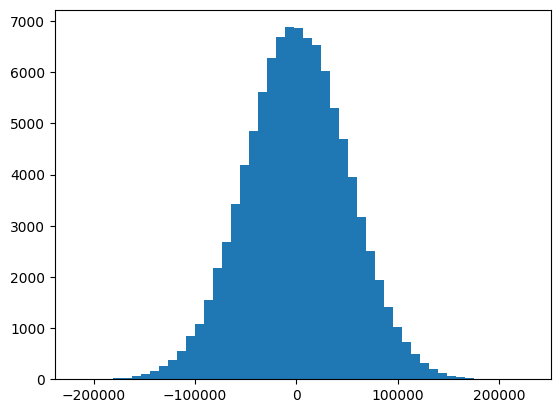

In [38]:
plt.hist(stock_reval_total, bins=50)

### full re-evaluation : swap ###

In [39]:
def simulate(dimension, power):
    simulation = qmc.Sobol(d=dimension, scramble=False)
    simulation = simulation.random_base2(m=power)
    simulation = np.delete(simulation, 0, axis=0)

    return simulation


sofr_simulation = simulate(swap_tenor_count, 18)

In [40]:
swap_diff_cov_cholesky = np.linalg.cholesky(
    sliced_sofr_raw_diff.corr(numeric_only=False).to_numpy()
)

In [41]:
independent_normals = norm.ppf(
    sofr_simulation, loc=sliced_sofr_raw_diff.mean(), scale=sliced_sofr_raw_diff.std()
)
print(independent_normals.shape)

(262143, 10)


In [42]:
correlated_normals = np.matmul(independent_normals, swap_diff_cov_cholesky)
correlated_normals.shape

(262143, 10)

In [43]:
df_correlated_normals = pd.DataFrame(correlated_normals.T, index=pv01.index)

In [44]:
for idx in sliced_curr_sofr_rate.index:
    df_correlated_normals.loc[idx] = (
        df_correlated_normals.loc[idx] + sliced_curr_sofr_rate[idx]
    )
df_correlated_normals

,0,1,2,3,4,5,6,7,8,9,...,262133,262134,262135,262136,262137,262138,262139,262140,262141,262142
Tenor,,,,,,,,,,,,,,,,,,,,,
1Y,0.052402,0.052792,0.052012,0.053150,0.053902,0.051745,0.050811,0.053342,0.055108,0.050588,...,0.050436,0.050868,0.050545,0.054075,0.050093,0.055719,0.047418,0.052613,0.054358,0.048304
2Y,0.048004,0.048336,0.047672,0.048837,0.048181,0.047381,0.047616,0.049306,0.049496,0.046122,...,0.046776,0.047375,0.047607,0.048477,0.045877,0.050305,0.045861,0.048169,0.049633,0.047383
3Y,0.045484,0.046010,0.044957,0.046002,0.045438,0.044951,0.045544,0.046194,0.046184,0.044637,...,0.045061,0.045215,0.045668,0.045341,0.044418,0.046387,0.044739,0.046036,0.046434,0.044989
4Y,0.044371,0.044671,0.044071,0.044633,0.044378,0.044030,0.044443,0.044665,0.044717,0.043932,...,0.044193,0.044231,0.044551,0.044265,0.043831,0.044717,0.043979,0.044716,0.044797,0.044131
5Y,0.043947,0.044205,0.043688,0.044125,0.043894,0.043636,0.044131,0.044186,0.044169,0.043678,...,0.043774,0.043934,0.044172,0.043821,0.043569,0.044165,0.043582,0.044309,0.044264,0.043749
6Y,0.043807,0.043977,0.043638,0.043997,0.043721,0.043515,0.043997,0.044019,0.044005,0.043600,...,0.043636,0.043858,0.044039,0.043751,0.043499,0.043966,0.043481,0.044085,0.044063,0.043642
7Y,0.043787,0.043906,0.043667,0.043931,0.043670,0.043622,0.043923,0.043905,0.043866,0.043694,...,0.043702,0.043783,0.044060,0.043749,0.043591,0.043882,0.043631,0.043938,0.043956,0.043659
8Y,0.043831,0.043883,0.043780,0.043888,0.043775,0.043775,0.043887,0.043872,0.043859,0.043803,...,0.043804,0.043820,0.043953,0.043816,0.043757,0.043866,0.043776,0.043888,0.043903,0.043776
9Y,0.043915,0.043929,0.043901,0.043925,0.043895,0.043905,0.043935,0.043914,0.043929,0.043914,...,0.043921,0.043907,0.043953,0.043913,0.043898,0.043926,0.043906,0.043935,0.043928,0.043895


In [45]:
# convert to disc factor
for i in range(1, len(df_correlated_normals.index) + 1):
    df_correlated_normals.iloc[i - 1] = df_correlated_normals.iloc[i - 1].apply(
        lambda x: np.exp(-x * i)
    )

In [46]:
df_correlated_normals

,0,1,2,3,4,5,6,7,8,9,...,262133,262134,262135,262136,262137,262138,262139,262140,262141,262142
Tenor,,,,,,,,,,,,,,,,,,,,,
1Y,0.948947,0.948577,0.949317,0.948237,0.947525,0.949571,0.950458,0.948056,0.946383,0.950670,...,0.950814,0.950404,0.950711,0.947361,0.951141,0.945805,0.953689,0.948747,0.947093,0.952844
2Y,0.908457,0.907855,0.909061,0.906945,0.908135,0.909590,0.909163,0.906095,0.905750,0.911883,...,0.910690,0.909600,0.909179,0.907597,0.912329,0.904285,0.912358,0.908157,0.905501,0.909587
3Y,0.872449,0.871071,0.873829,0.871093,0.872569,0.873845,0.872292,0.870591,0.870619,0.874669,...,0.873555,0.873151,0.871967,0.872822,0.875242,0.870087,0.874400,0.871004,0.869965,0.873745
4Y,0.837375,0.836371,0.838380,0.836498,0.837351,0.838517,0.837133,0.836391,0.836217,0.838846,...,0.837972,0.837844,0.836772,0.837728,0.839186,0.836216,0.838689,0.836221,0.835948,0.838179
5Y,0.802733,0.801696,0.803772,0.802018,0.802943,0.803981,0.801993,0.801772,0.801839,0.803812,...,0.803424,0.802784,0.801829,0.803238,0.804249,0.801857,0.804198,0.801282,0.801458,0.803525
6Y,0.768862,0.768080,0.769644,0.767990,0.769259,0.770212,0.767988,0.767888,0.767952,0.769821,...,0.769654,0.768627,0.767793,0.769123,0.770284,0.768129,0.770366,0.767581,0.767685,0.769627
7Y,0.736014,0.735397,0.736631,0.735269,0.736613,0.736860,0.735312,0.735404,0.735603,0.736489,...,0.736451,0.736032,0.734607,0.736208,0.737020,0.735520,0.736818,0.735235,0.735142,0.736672
8Y,0.704231,0.703941,0.704521,0.703913,0.704545,0.704549,0.703917,0.704001,0.704077,0.704391,...,0.704381,0.704295,0.703545,0.704315,0.704649,0.704035,0.704542,0.703908,0.703825,0.704543
9Y,0.673520,0.673436,0.673604,0.673458,0.673641,0.673581,0.673398,0.673528,0.673437,0.673527,...,0.673486,0.673571,0.673289,0.673535,0.673626,0.673453,0.673576,0.673400,0.673443,0.673644


In [47]:
reval_swap_list = []
for cols in df_correlated_normals.columns:
    temp_pv_fix = (
        df_correlated_normals.loc["1Y", cols]
        + df_correlated_normals.loc["2Y", cols]
        + df_correlated_normals.loc["3Y", cols]
        + df_correlated_normals.loc["4Y", cols]
        + df_correlated_normals.loc["5Y", cols]
        + df_correlated_normals.loc["6Y", cols]
        + df_correlated_normals.loc["7Y", cols]
        + df_correlated_normals.loc["8Y", cols]
        + df_correlated_normals.loc["9Y", cols]
        + df_correlated_normals.loc["10Y", cols]
    ) * fixed_rate
    temp_pv_float = 1 - df_correlated_normals.loc["10Y", cols]
    temp_pv_total = temp_pv_float - temp_pv_fix
    reval_swap_list.append(temp_pv_total)

In [48]:
for_swap_var_calc = (reval_swap_list - pv_total) * swap_notional

In [49]:
var_swap_mc_reval = abs(np.percentile(for_swap_var_calc, var_percentile))

In [50]:
print(
    f"VaR of stock (monte carlo reval) : {var_stock_mc_reval} ; VaR of swap (monte carlo reval) :{var_swap_mc_reval}"
)

VaR of stock (monte carlo reval) : 83062.8057481289 ; VaR of swap (monte carlo reval) :120208.90339663668
